In [ ]:
!pip install split-folders

In [2]:
import splitfolders
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

%matplotlib inline

In [3]:
DATASET_DIR = r"C:\Users\patel\Downloads\Dataset\Mendeley"

In [ ]:
# Split folder into train, test and validation set.
splitfolders.ratio(r"C:\Users\patel\Downloads\Dataset\Mendeley\\", output=r"C:\Users\patel\Downloads\Dataset\Mendeley\\", seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 14894 files [15:11, 16.34 files/s]


In [4]:
train_dir = DATASET_DIR + "/train"
valid_dir = DATASET_DIR + "/valid"
diseases = os.listdir(train_dir)

diseases = [item for item in diseases]

print(diseases)

['anthracnose', 'bacterial blight', 'brown spot', 'fall armyworm', 'grasshoper', 'green mite', 'gumosis', 'leaf curl', 'red rust', 'septoria leaf spot', 'streak virus', 'verticulium wilt']


In [5]:
print(f"Total classes are: {len(diseases)}")

Total classes are: 12


In [6]:
nums = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases}

# Converting the nums dictionary to pandas DataFrame with plant name as index and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])

img_per_class

,No. of images
anthracnose,1383
bacterial blight,2099
brown spot,1184
fall armyworm,228
grasshoper,538
green mite,812
gumosis,313
leaf curl,414
red rust,1345
septoria leaf spot,2194


In [7]:
sum([len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases])

11909

<Figure size 1000x600 with 0 Axes>

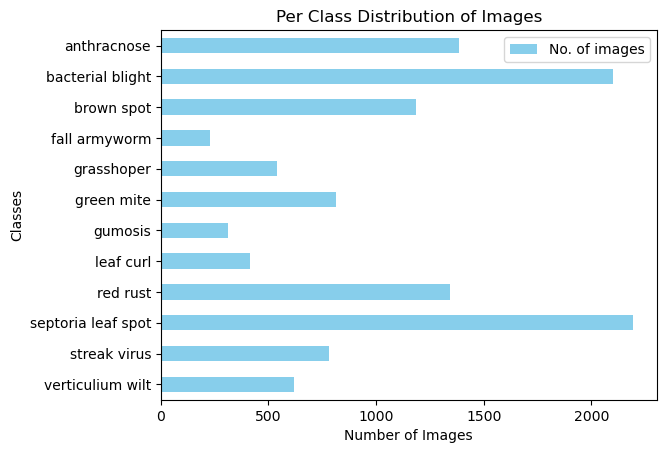

In [8]:
plt.figure(figsize=(10, 6))
img_per_class.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.title('Per Class Distribution of Images')
plt.gca().invert_yaxis()
plt.show()

In [9]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
def is_valid_file(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        return False

In [11]:
batch_size=32

In [12]:
train_dataset = ImageFolder(root=r"C:\Users\patel\Downloads\Dataset\Mendeley\train", transform=train_transforms, is_valid_file=is_valid_file)
val_dataset = ImageFolder(root=r"C:\Users\patel\Downloads\Dataset\Mendeley\val", transform=val_transforms, is_valid_file=is_valid_file)
test_dataset = ImageFolder(root=r"C:\Users\patel\Downloads\Dataset\Mendeley\test", transform=val_transforms, is_valid_file=is_valid_file)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


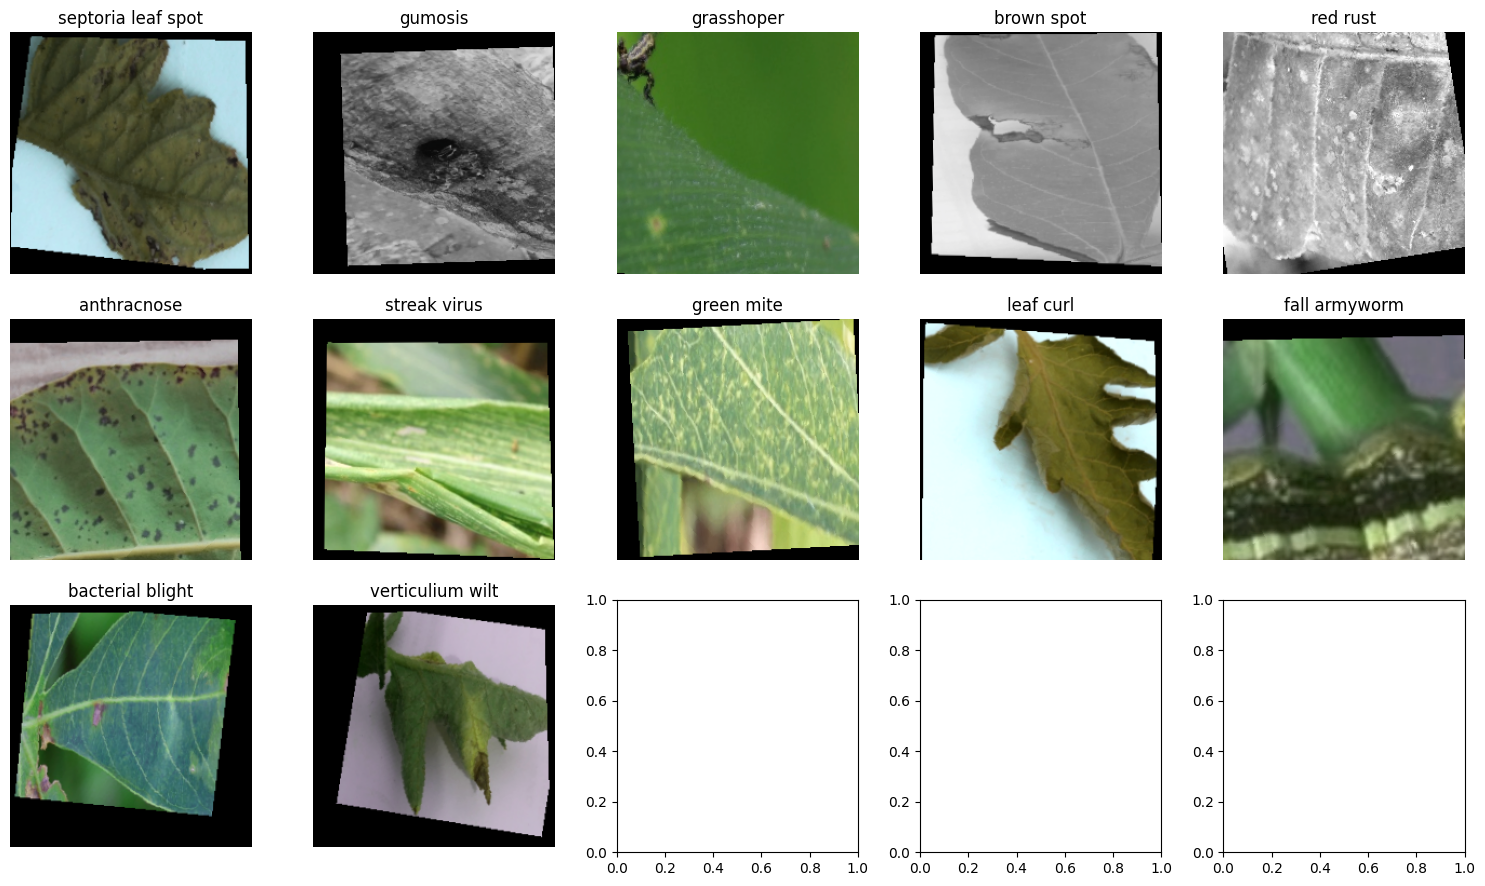

In [ ]:
unique_classes = set()
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
num_rows = math.ceil(num_classes/5)
num_cols = min(5, num_classes)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

row_index = 0
col_index = 0

for images, labels in train_loader:
    images = [img for img in images if img is not None]
    labels = [label for label, img in zip(labels, images) if img is not None]
    images = torch.stack(images)
    for image, label in zip(images, labels):

        class_name = idx_to_class[label.item()]
        try:
          if class_name not in unique_classes:
              unique_classes.add(class_name)
              ax = axes[row_index, col_index]
              img = image.numpy().transpose((1, 2, 0))
              mean = np.array([0.485, 0.456, 0.406])
              std = np.array([0.229, 0.224, 0.225])
              img = std * img + mean
              img = np.clip(img, 0, 1)

              ax.imshow(img)
              ax.set_title(class_name)
              ax.axis('off')

              col_index += 1
              if col_index == num_cols:
                  col_index = 0
                  row_index += 1
        except (OSError,Exception) as e:
          continue

        if len(unique_classes) == num_classes:
            break
    if len(unique_classes) == num_classes:
        break

plt.tight_layout()
plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.resnet18(pretrained=True)
model.to(device)

Device: cuda


c:\Users\patel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
BEST_MODEL_PATH=r"C:\Users\patel\Downloads\Dataset\Mendeley\ResNet_Mendeley_Tune.pth"

In [20]:
learning_rates = [0.0001, 0.01, 0.1]

In [21]:
results = {}
num_epochs = 10
early_stopping_patience = 5

for lr in learning_rates:
    print(f"Training with learning rate: {lr}\n")
    
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Train the model
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == early_stopping_patience:
            print('Early stopping initiated...')
            break
    
    # Model evaluation
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    test_correct = 0
    test_total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_accuracy = test_correct / test_total
    print(f'\n\nTest Accuracy: {test_accuracy:.4f}\n\n')

    results[lr] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

Training with learning rate: 0.0001



c:\Users\patel\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


OSError: Caught OSError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\patel\anaconda3\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\patel\anaconda3\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\patel\anaconda3\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\patel\anaconda3\Lib\site-packages\torchvision\datasets\folder.py", line 229, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "c:\Users\patel\anaconda3\Lib\site-packages\torchvision\datasets\folder.py", line 268, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "c:\Users\patel\anaconda3\Lib\site-packages\torchvision\datasets\folder.py", line 248, in pil_loader
    return img.convert("RGB")
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\patel\anaconda3\Lib\site-packages\PIL\Image.py", line 941, in convert
    self.load()
  File "c:\Users\patel\anaconda3\Lib\site-packages\PIL\ImageFile.py", line 310, in load
    raise _get_oserror(err_code, encoder=False)
OSError: broken data stream when reading image file


In [ ]:
# Plotting training and validation curves for each learning rate
plt.figure(figsize=(12, 8))
for lr, result in results.items():
    plt.plot(result['train_losses'], label=f'Train Loss (LR={lr})')
    plt.plot(result['val_losses'], label=f'Val Loss (LR={lr})')

plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for lr, result in results.items():
    plt.plot(result['train_accuracies'], label=f'Train Accuracy (LR={lr})')
    plt.plot(result['val_accuracies'], label=f'Val Accuracy (LR={lr})')

plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()